<h1>Credit Risk Analysis with XGBOOST</h1>

@syahrulmwijaya

<h2>Importing All Important Libraries and Dataset</h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/loan/loan.csv')
per70 = int(len(df)*0.7)
df = df.iloc[:per70].copy()
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Simple Data Explorations</h2>

as stated in the dataset that there are many 'object' type datas, so the data need to be looked again to see which column has 'object' type

In [3]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,6.211650e+05,6.211650e+05,621165.000000,621165.000000,621165.000000,621165.000000,621165.000000,6.211610e+05,621165.000000,621136.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,5.508890e+05,21372.000000,21372.000000,21372.000000
mean,2.570344e+07,2.793547e+07,14539.196510,14520.072243,14465.908482,13.447909,433.830662,7.461915e+04,17.760608,0.299909,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.162268e+04,0.943945,1.537058,1.977307
std,2.390193e+07,2.532075e+07,8387.875109,8379.389305,8396.767519,4.371230,244.344197,6.414029e+04,19.741341,0.828742,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.680835e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,5.959082e+06,7.217834e+06,8000.000000,8000.000000,8000.000000,10.150000,257.360000,4.500000e+04,11.650000,0.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.380000e+04,0.000000,0.000000,0.000000
50%,1.612213e+07,1.798332e+07,12550.000000,12500.000000,12475.000000,13.160000,380.730000,6.400000e+04,17.300000,0.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.350000e+04,0.000000,0.000000,2.000000
75%,3.778036e+07,4.053432e+07,20000.000000,20000.000000,20000.000000,16.290000,569.450000,9.000000e+04,23.430000,0.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.930000e+04,1.000000,2.000000,3.000000
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.000000e+06,9999.000000,30.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


In [4]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"column {column} has object type")
        #print(f'with values = {df[column].unique()}')

column term has object type
column grade has object type
column sub_grade has object type
column emp_title has object type
column emp_length has object type
column home_ownership has object type
column verification_status has object type
column issue_d has object type
column loan_status has object type
column pymnt_plan has object type
column url has object type
column desc has object type
column purpose has object type
column title has object type
column zip_code has object type
column addr_state has object type
column earliest_cr_line has object type
column initial_list_status has object type
column last_pymnt_d has object type
column next_pymnt_d has object type
column last_credit_pull_d has object type
column application_type has object type
column verification_status_joint has object type


In [5]:
df['emp_title'].unique()

array([nan, 'Ryder', 'AIR RESOURCES BOARD', ..., 'District mgr ',
       'agent assistant', 'Lead Wrapper'], dtype=object)

In [6]:
loan_status = df['loan_status'].value_counts()
loan_status

loan_status
Current                                                366627
Fully Paid                                             187388
Charged Off                                             42479
Issued                                                   8460
Late (31-120 days)                                       7249
In Grace Period                                          3940
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1441
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

Then, let's see how the balance of target variable is

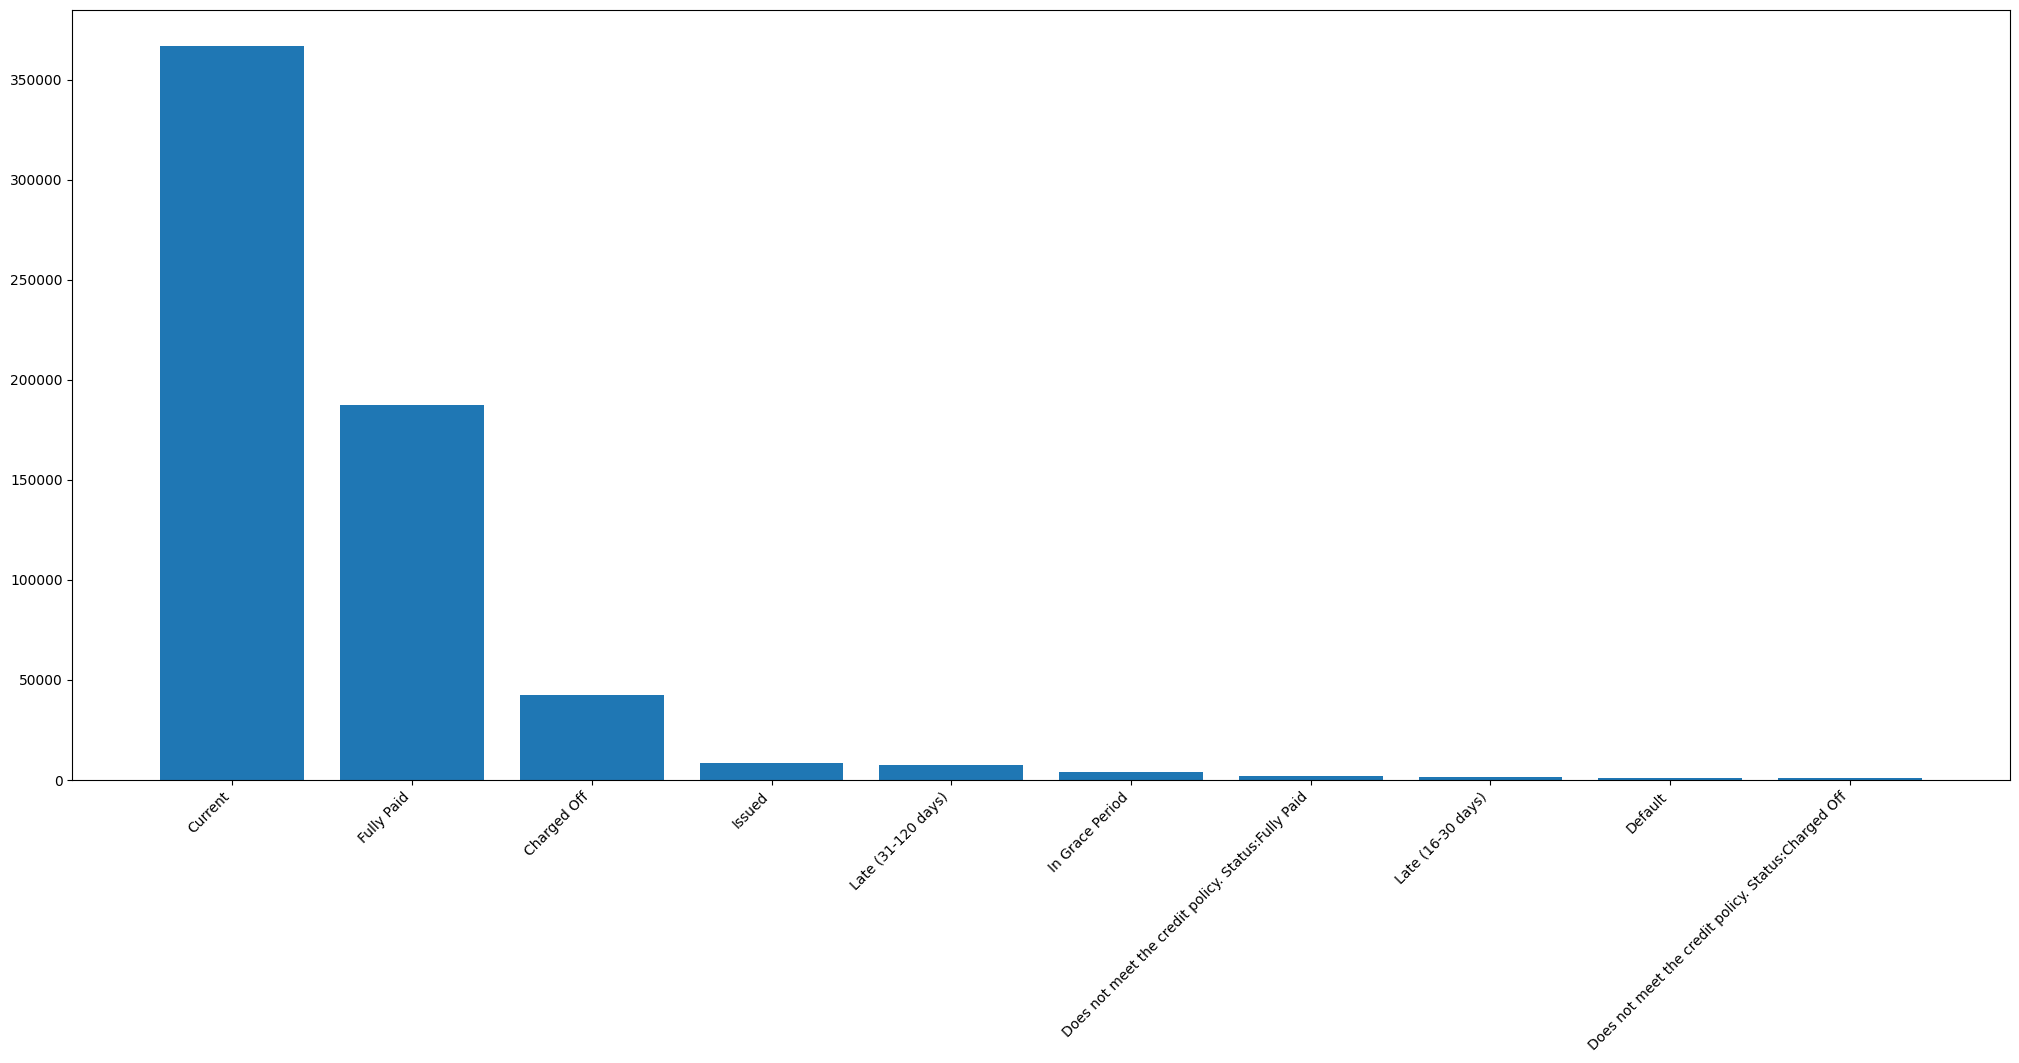

In [7]:
fig, ax = plt.subplots(figsize =(25,10))
plt.bar(loan_status.index, height=loan_status)
plt.xticks(rotation=45, ha='right', fontsize=10);
plt.show()

<h2>Feature Selection</h2>

In [8]:
print(df.columns)
print(f'total variables {len(df.columns)}')

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [9]:
df['acc_now_delinq'].unique()

array([ 0.,  1., nan,  2.,  3.,  5.,  4.])

pick feature that not gonna be used

In [10]:
excludes = ['desc', 'emp_title', 'id', 'member_id', 'next_pymnt_d', 'policy_code','url', 'zip_code', 'title', 'earliest_cr_line', 'last_pymnt_d','last_credit_pull_d', 'pymnt_plan', 'addr_state','mths_since_last_major_derog', 'application_type', 'annual_inc_joint', 'dti_joint', 'verified_status_joint' ,'open_acc_6m', 'open_il_6m', 'verification_status_joint']
excludes.extend(df.columns[-17:])

In [11]:
df_new = df[[feature for feature in df.columns if feature not in excludes]].copy()
df_new.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,0.0


In [12]:
df_new.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq'],
      dtype='object')

In [13]:
for column in df_new.columns:
    if df_new[column].dtype == 'object':
        print(f"column {column} has object type")

column term has object type
column grade has object type
column sub_grade has object type
column emp_length has object type
column home_ownership has object type
column verification_status has object type
column issue_d has object type
column loan_status has object type
column purpose has object type
column initial_list_status has object type


<h2>Data Preparation</h2>

<h3>Encoding All Objects Categorical Features</h3>

encoder that will be used is the One-HotEncoder which will has no bias to the model when applied.

In [14]:
encoder = OneHotEncoder(sparse=False, drop=None)
test_encoder = pd.DataFrame()
test_encoder['term'] = df_new['term'].copy()
encoded_data = encoder.fit_transform(test_encoder)
result = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out()).astype(int)
result

,term_ 36 months,term_ 60 months
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
621160,1,0
621161,1,0
621162,1,0
621163,1,0


The reason why applying the one-hot encoding is that the one-hot encoding will leave no bias to the model when applied to model compared to standard label encoding. 
<br>
In standard label encoding, the higher order the code in encoding that label will be more prioritized so will leave bias to model

In [15]:
encoder_list = {}
clear_df = df_new.copy()
for column in clear_df.columns:
    if clear_df[column].dtype == 'object':
        print(column)
        encoder = OneHotEncoder(sparse=False, drop=None)
        
        test_encoder = pd.DataFrame()
        test_encoder[column] = clear_df[column].copy()
        encoder_list[column] = encoder.fit(test_encoder)
        encoded_data = encoder.transform(test_encoder)

        result = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out()).astype(int)
        clear_df = pd.concat([clear_df, result], axis=1)
        clear_df.drop(column, axis=1, inplace=True)
        

term
grade
sub_grade
emp_length
home_ownership
verification_status
issue_d
loan_status
purpose
initial_list_status


In [16]:
df_new

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621160,8800.0,8800.0,8800.0,36 months,12.69,295.20,C,C2,1 year,RENT,...,1165.290000,1165.29,821.48,343.81,0.00,0.00,0.00,295.20,0.0,0.0
621161,14000.0,14000.0,14000.0,36 months,10.99,458.28,B,B4,8 years,RENT,...,1811.750000,1811.75,1338.50,473.25,0.00,0.00,0.00,458.28,0.0,0.0
621162,7500.0,7500.0,7500.0,36 months,6.24,228.99,A,A2,3 years,MORTGAGE,...,909.460000,909.46,765.91,143.55,0.00,0.00,0.00,228.99,0.0,0.0
621163,25000.0,25000.0,25000.0,36 months,6.24,763.28,A,A2,10+ years,OWN,...,3035.790000,3035.79,2552.95,482.84,0.00,0.00,0.00,763.28,0.0,0.0


In [17]:
list_missing = []
for column in df_new.columns:
    if df_new[column].isna().any():
        #df_new[column].fillna(0, inplace=True)
        list_missing.append(column)
        print(f'there is missing value in column {column} ')

print(f'there is total {len(list_missing)} that has missing value')        


there is missing value in column emp_length 
there is missing value in column annual_inc 
there is missing value in column delinq_2yrs 
there is missing value in column inq_last_6mths 
there is missing value in column mths_since_last_delinq 
there is missing value in column mths_since_last_record 
there is missing value in column open_acc 
there is missing value in column pub_rec 
there is missing value in column revol_util 
there is missing value in column total_acc 
there is missing value in column collections_12_mths_ex_med 
there is missing value in column acc_now_delinq 
there is total 12 that has missing value


In [18]:
for column in df_new.columns:
    if df_new[column].isna().any():
        df_new[column].fillna(0, inplace=True)

In [19]:
for column in df_new.columns:
    if df_new[column].isna().any():
        print(f'there is missing value in column {column} ')

In [20]:
df_new

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621160,8800.0,8800.0,8800.0,36 months,12.69,295.20,C,C2,1 year,RENT,...,1165.290000,1165.29,821.48,343.81,0.00,0.00,0.00,295.20,0.0,0.0
621161,14000.0,14000.0,14000.0,36 months,10.99,458.28,B,B4,8 years,RENT,...,1811.750000,1811.75,1338.50,473.25,0.00,0.00,0.00,458.28,0.0,0.0
621162,7500.0,7500.0,7500.0,36 months,6.24,228.99,A,A2,3 years,MORTGAGE,...,909.460000,909.46,765.91,143.55,0.00,0.00,0.00,228.99,0.0,0.0
621163,25000.0,25000.0,25000.0,36 months,6.24,763.28,A,A2,10+ years,OWN,...,3035.790000,3035.79,2552.95,482.84,0.00,0.00,0.00,763.28,0.0,0.0


In [21]:
for feature in df_new.columns:
    if '<' in feature:
        df_new.rename(columns={feature: feature.replace('<', 'less')}, inplace=True)

<h3>Handling Missing Values</h3>

In [22]:
for column in df_new.columns:
    if df_new[column].isna().any():
        print(f"there is missing value in {column} with total {df_new[column].isna().count()}")

In [23]:
df_new.shape

(621165, 38)

as what inspected that the data now has no any missing values in it, and is ready to be modelled

<h3>Data Splitting</h3>

Because of the One-Hot Encoding, the problem of credit risk analysis become multi-class classification

In [35]:
targets = [feature for feature in clear_df.columns if 'loan_status' in feature]
features = [feature for feature in clear_df.columns if feature not in targets]
targets

['loan_status_Charged Off',
 'loan_status_Current',
 'loan_status_Default',
 'loan_status_Does not meet the credit policy. Status:Charged Off',
 'loan_status_Does not meet the credit policy. Status:Fully Paid',
 'loan_status_Fully Paid',
 'loan_status_In Grace Period',
 'loan_status_Issued',
 'loan_status_Late (16-30 days)',
 'loan_status_Late (31-120 days)']

Split data into test and train sets

In [36]:
per80 = int(len(df_new)*0.8)
train_df = clear_df.iloc[:per80]
test_df = clear_df.iloc[per80:]
test_df.shape 

(124233, 215)

In [37]:
train_df.shape

(496932, 215)

since the problem is multi-class classification, so the model is kinda different from standard classifier.

<h2>Modelling The Machine Learning Model</h2>

First make the model configuration
<br>
<br>
Here, the objective is 'multi' this means that the model will be used to perform solution in multi-classes problem.

Training session with from Stratified K-Fold Cross-Validation strategy

In [38]:
k = 5  
stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [39]:
for feature in train_df.columns:
    if '<' in feature:
        print(feature)
        #df_new.rename(columns={feature: feature.replace('<', 'less')}, inplace=True)

emp_length_< 1 year


In [40]:
train_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq',
       ...
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'initial_list_status_f',
       'initial_list_status_w'],
      dtype='object', length=215)

In [41]:
params = {
    'objective': 'multi:softmax',
    'num_class': len(targets),
    'max_depth': 5,
    'learning_rate': 0.001,
    'n_estimators': 10000
}
#model = xgb.XGBClassifier(**params)
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=1000,
                          max_depth=5,
                          learning_rate=0.001,
                          base_score=0.5,
                          multi_strategy="multi_output_tree")
#model = MultiOutputClassifier(model)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=int(len(train_df)/5*0.2), gap=24)
for train_idx, val_idx in tss.split(train_df):
    train = train_df.iloc[train_idx]
    valid = train_df.iloc[val_idx]

    X_train = train[features]
    y_train = train[targets]

    X_val = valid[features] 
    y_val = valid[targets]

    #print(y_train)
    #break


    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)
    #break
    #model.fit(X_train, y_train,
    #        eval_set=[(X_train, y_train), (X_val, y_val)],
    #        verbose=500)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=500
    )

(397523, 294)
(397523, 2)
(19877, 294)
(19877, 2)
[07:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "multi_strategy" } are not used.

[0]	validation_0-logloss:0.68320	validation_1-logloss:0.68320
[500]	validation_0-logloss:0.00333	validation_1-logloss:0.00333
[999]	validation_0-logloss:0.00003	validation_1-logloss:0.00003
(417400, 294)
(417400, 2)
(19877, 294)
(19877, 2)
[07:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "multi_strategy" } are not used.

[0]	validation_0-logloss:0.68320	validation_1-logloss:0.68320
[500]	validation_0-logloss:0.00333	validation_1-logloss:0.00333
[999]	validation_0-logloss:0.00003	validation_1-logloss:0.00003
(437277, 294)
(437277, 2)
(19877, 294)
(19877, 2)
[08:07:08] WARNING: C:\buildkite-agent\builds\buildkite-window

In [ ]:
model.save_model('model_creditv1.h5')

In [42]:
# Load the model
loaded_model = xgb.Booster(model_file='model_creditv1.h5')


In [43]:
loaded_model.attributes

<bound method Booster.attributes of <xgboost.core.Booster object at 0x00000195D011F390>>